### Libraries

In [40]:
#Data Manipulation
import pandas as pd
import numpy as np

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

#Utilities
import time
import warnings
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.utils import shuffle
from tqdm import tqdm

#Models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
parameters = {
    "dataset":{
        "path": "../data/Processed_Data/Demand_Dataset.csv",
        "trainingSize": .70,
        "validationSize": .15,
        "testSize": .15
    },
    "backtesting":{
        "steps": 96,
        "fixedTrainSize": False,
        "refit": False,
    },
    "validation": {
        "n_splits" : 10
    }
}

In [41]:
def plotDatasetSplit(X_train, X_train_dates, X_test, X_test_dates):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X_train_dates, y=X_train["Demand"], mode="lines", name="Train"))
    fig.add_trace(go.Scatter(x=X_test_dates, y=X_test["Demand"], mode="lines", name="Test"))
    fig.update_layout(
        title = "Dataset Partition",
        xaxis_title = "Date",
        yaxis_title ="Demand (MWh)",
        width = 1000,
        height = 400,
        margin = dict(l=30, r=20, t=35, b=60),
        legend = dict(
            orientation = "h",
            yanchor = "bottom",
            y = 1.05,
            xanchor = "right",
            x=1
        )
    )
    fig.show()

In [42]:
def plotPredictions(dates, y_pred, y_test):
    fig = go.Figure()
    trace1 = go.Scatter(x=dates, y=y_test, name="test", mode="lines")
    trace2 = go.Scatter(x=dates, y=y_pred, name="predictions", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Real value vs Predicted in Test Data",
        xaxis_title="Date Time",
        yaxis_title="Demand",
        width=1020,
        height=450,
        margin = dict(l=70, r=20, t=55, b=20),
        legend = dict(
            orientation = "h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.76
        )
    )
    fig.show()

In [ ]:
from sklearn.utils import shuffle
def permutation_feature_importance(model, X_test, y_test, feature_names):
    y_pred = model.predict(X_test, verbose=False)
    #rmse_ref = root_mean_squared_error(y_test.flatten(), y_pred.flatten())
    mae_ref = mean_absolute_error(y_test, y_pred)

    feature_importance = np.zeros(X_test.shape[1])

    for i in tqdm(range(X_test.shape[1]), total=(X_test.shape[1])):
        #Make a Copy of the Test Subset and Permute its values
        X_test_permuted = X_test.copy()
        X_test_permuted[:, i] = shuffle(X_test_permuted[:, i])

        #Calculate the metrics
        y_pred_permuted = model.predict(X_test_permuted, verbose=False)
        #rmse_permuted = root_mean_squared_error(y_test.flatten(), y_pred_permuted.flatten())
        mae_permuted = mean_absolute_error(y_test, y_pred_permuted)

        #Calculate the difference in the metrics
        feature_importance[i] = mae_ref - mae_permuted
    
    #Normalize feature importances
    feature_importance /= feature_importance.sum()

    #Sort indexes
    sorted_indexes = feature_importance.argsort()[::-1]
    sorted_importances = feature_importance[sorted_indexes]
    sorted_importances_names = feature_names[sorted_indexes]

    #Bar Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_importances_names)
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Feature Permutation Importance')
    plt.show()

In [43]:
def addNLags(df, lags=1):
    lag_df = df.copy()
    for i in range(1, lags + 1):
        lag_df[f'lag_{i}'] = lag_df['Demand'].shift(i)
    return lag_df.dropna()

In [44]:
def normalizeData(data):
    df = data.copy()
    df = df.drop("Demand", axis=1)
    scaler = MinMaxScaler()
    return scaler.fit_transform(df)

## Machine Learning Models

### Split Dataset

In [45]:
df2 = pd.read_csv(parameters["dataset"]["path"], index_col=None)
dates = df2["Date"]
df2 = df2.drop(columns=["Date"])

trainingSize = int((parameters["dataset"]["trainingSize"] + parameters["dataset"]["validationSize"])* df2.shape[0])

X_train = df2.loc[:trainingSize, :].copy()
X_train_dates = dates.loc[:trainingSize].copy()
X_test = df2.loc[trainingSize:, :].copy()
X_test_dates = dates.loc[trainingSize:].copy()

print(f"Training and Validation Size: {trainingSize}")
print(f"Test Size: {len(df2)-trainingSize}")

Training and Validation Size: 59568
Test Size: 10512


In [46]:
plotDatasetSplit(X_train, X_train_dates, X_test, X_test_dates)

### Models to Test

In [47]:
models, models_names = [], []

#Tree Models

for n in [20, 50]:
    LGBM = LGBMRegressor(n_estimators=n, random_state=123, verbose=-1)
    XGB = XGBRegressor(n_estimators=n, random_state=123)
    GBM = GradientBoostingRegressor(n_estimators=n, random_state=123)
    models.append(LGBM)
    models_names.append("LGBM_" + str(n))
    models.append(XGB)
    models_names.append("XGB_" + str(n))
    models.append(GBM)
    models_names.append("GBM_" + str(n))


#KNNr
for n in [10, 20]:
    KNNR = KNeighborsRegressor(n_neighbors=n, weights = 'uniform')
    models.append(KNNR)
    models_names.append("KNNr_" + str(n) + "_" + 'uniform')
        
#Other Models
#models.append(SVR(kernel='rbf'))
#models_names.append("SVR")

### Walking Forward Validation

In [48]:
from sklearn.model_selection import TimeSeriesSplit
def walkForwardValidation(X, y, X_test, y_test, models, models_names, params, plot=False):
    n_splits = params['validation']['n_splits']
    results = pd.DataFrame(columns=["Model", "RMSE_Test", "RMSE_Val", "MAE_Test", "MAE_Val","Mean_MRSE_Test", "Mean_MAE_Test", "Mean_RMSE_Val", "Mean_MAE_Val"])
    for model, model_name in tqdm(zip(models, models_names), total=len(models)):
        tscv = TimeSeriesSplit(n_splits=n_splits)
        rmse_test, rmse_val, mae_test, mae_val = [], [], [], []
        for i, (train_index, eval_index) in enumerate(tscv.split(X)):
            X_train, X_val = X[train_index], X[eval_index]
            y_train, y_val = y[train_index], y[eval_index]
            model.fit(X_train, y_train)

            #Validation Scores
            y_pred_val = model.predict(X_val)
            mae_val.append(mean_absolute_error(y_val, y_pred_val))
            rmse_val.append(root_mean_squared_error(y_val, y_pred_val))
            
            #Test Scores
            y_pred_test = model.predict(X_test)
            mae_test.append(mean_absolute_error(y_test, y_pred_test))
            rmse_test.append(root_mean_squared_error(y_test, y_pred_test))
            
        print(f"Model: {model_name} ===> Mean Test MAE: {np.mean(mae_test)}, RMSE: {np.mean(rmse_test)}")
        results.loc[len(results.index)] = [model_name, rmse_test, rmse_val, mae_test, mae_val, np.mean(rmse_test), np.mean(mae_test), np.mean(rmse_val), np.mean(mae_val)] 
    
    #Plots
    if plot:
        titles = ["RMSE Evolution in Validation", "MAE Evolution in Validation", "RMSE Evolution in Test", "MAE Evolution in Test"]
        metric_names = ["RMSE_Val", "MAE_Val", "RMSE_Test", "MAE_Test"]
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
        for i in range(4):
            metric_name = metric_names[i]
            title = titles[i]
            row = i // 2
            col = i % 2
            ax = axes[row, col]
            for index, row in results.iterrows():
                model_name = row["Model"]
                metric_values = row[metric_name]
                ax.plot(metric_values, label=model_name)

            ax.set_title(title)
            ax.set_xlabel("Fold")
            ax.set_ylabel(metric_name)
            ax.legend()
            ax.grid(True)

        plt.tight_layout()
        plt.show()
        
    return results

 12%|█▎        | 1/8 [00:00<00:06,  1.10it/s]

Model: LGBM_20 ===> Mean Test MAE: 24.597111902522837, RMSE: 37.306527137304585


 25%|██▌       | 2/8 [00:01<00:05,  1.10it/s]

Model: XGB_20 ===> Mean Test MAE: 26.526175921696172, RMSE: 39.25831194233332


 38%|███▊      | 3/8 [00:14<00:32,  6.50s/it]

Model: GBM_20 ===> Mean Test MAE: 25.38754151567513, RMSE: 35.56780308426286


 50%|█████     | 4/8 [00:16<00:18,  4.52s/it]

Model: LGBM_50 ===> Mean Test MAE: 23.46352887129626, RMSE: 37.5603343843031


 62%|██████▎   | 5/8 [00:18<00:10,  3.64s/it]

Model: XGB_50 ===> Mean Test MAE: 28.053814556545763, RMSE: 40.66839191534099


 75%|███████▌  | 6/8 [00:51<00:27, 13.71s/it]

Model: GBM_50 ===> Mean Test MAE: 25.529309201079677, RMSE: 36.212856621539444


 88%|████████▊ | 7/8 [01:01<00:12, 12.51s/it]

Model: KNNr_10_uniform ===> Mean Test MAE: 26.756948249619484, RMSE: 44.175597602842906


100%|██████████| 8/8 [01:11<00:00,  8.96s/it]

Model: KNNr_20_uniform ===> Mean Test MAE: 25.628521689497717, RMSE: 41.16161565199697


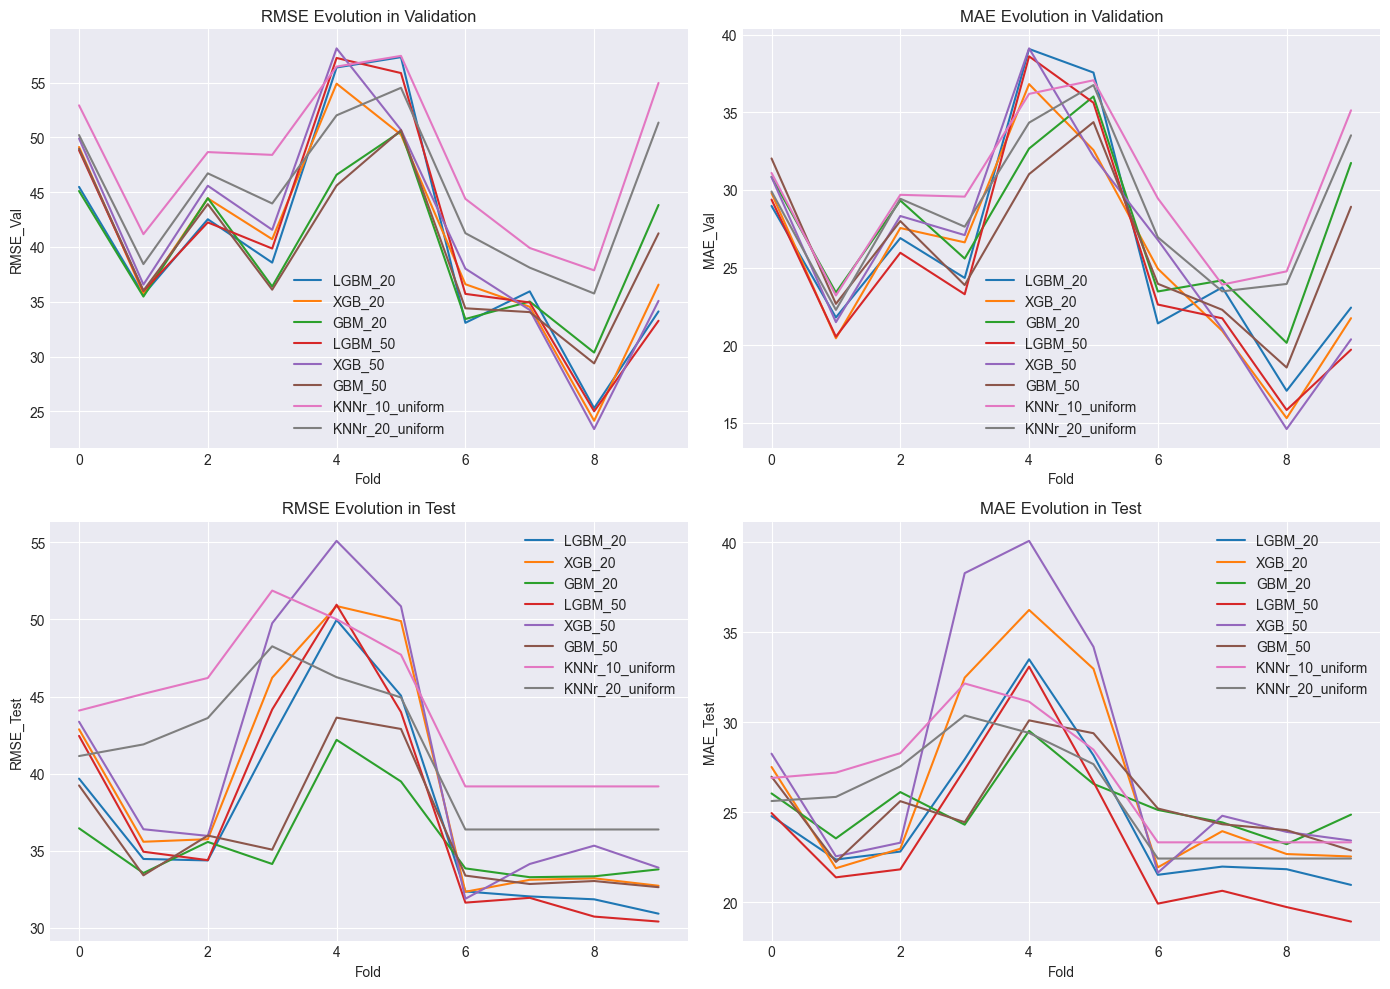

In [49]:
	
results = walkForwardValidation(normalizeData(X_train), X_train["Demand"], normalizeData(X_test), X_test["Demand"], models, models_names, parameters, plot=True)
results.to_csv("../data/Processed_Data/Walking_Forward_Validation.csv", index=None)

### K-Fold Cross Validation

In [50]:
def KFoldCrossValidation(X, y, models, model_names, params):
    results = []
    k = params["validation"]["n_splits"]
    for model, name in tqdm(zip(models, model_names), total=len(models), desc="Models Validation"):
        model_list, mae_list , rmse_list = [name], [], []
        fold_size = len(X) // k
        fold_indices = []
        for i in range(k):
            start_idx = i * fold_size
            end_idx = start_idx + fold_size if i < k - 1 else len(X)

            fold_indices.append((np.arange(start_idx, end_idx), np.concatenate((np.arange(0, start_idx), np.arange(end_idx, len(X))))))

        for fold_idx, (train_idx, test_idx) in enumerate(fold_indices):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mae_list.append(mean_absolute_error(y_test, y_pred))
            rmse_list.append(root_mean_squared_error(y_test, y_pred))

        model_list.extend(mae_list)
        model_list.extend(rmse_list)
        model_list.extend([np.mean(mae_list), np.mean(rmse_list)])
        results.append(model_list)
    columns = ["model", "k0_mae", "k1_mae", "k2_mae", "k3_mae", "k4_mae", "k5_mae", "k6_mae", "k7_mae", "k8_mae", "k9_mae",
        "k0_rmse", "k1_rmse", "k2_rmse", "k3_rmse", "k4_rmse", "k5_rmse", "k6_rmse", "k7_rmse", "k8_rmse", "k9_rmse", "mae_mean", "rmse_mean"]
    df = pd.DataFrame(results, columns=columns)
    
    return df

In [51]:
#Cross Validation
results = KFoldCrossValidation(
    normalizeData(X_train), X_train["Demand"], models, models_names, parameters
)

Models Validation: 100%|██████████| 8/8 [00:25<00:00,  3.24s/it]


In [52]:
results.sort_values(by=["mae_mean", "rmse_mean"])
results.to_csv('../data/Processed_Data/KFold_Validation_Results.csv', index=None)

### Test

In [53]:
def test(X_test2, model):
    X_test = X_test2.copy()
    X_test, y_test = normalizeData(X_test), X_test["Demand"]
    #Predict
    y_pred = model.predict(X_test)

    #Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    return mae, rmse



In [54]:
def checkModelswTest(X_test, models, models_names):
    results = pd.DataFrame(columns=["Model", "MAE_All", "RMSE_All", "MAE_Week", "RMSE_Week","MAE_Day", "RMSE_Day"])
    for model, model_name in tqdm(zip(models, models_names), total=len(models)):
        #Predict All Test
        all_mae, all_rmse = test(X_test, model)
        
        #Predict One Week Test
        week_mae, week_rmse = test(X_test.iloc[:96*7], model)

        #Predict One Day Test
        day_mae, day_rmse = test(X_test.iloc[:96], model)

        results.loc[len(results.index)] = [model_name, all_mae, all_rmse, week_mae, week_rmse, day_mae, day_rmse] 
        
    return results

# Testing
results = checkModelswTest(X_test, models, models_names)
results

100%|██████████| 8/8 [00:00<00:00, 13.14it/s]


Model    MAE_All   RMSE_All   MAE_Week  RMSE_Week    MAE_Day  \
0          LGBM_20  32.278719  46.342498  24.305741  35.615838  37.370419   
1           XGB_20  32.806886  47.231689  26.190949  40.169097  45.135583   
2           GBM_20  29.934826  38.249611  23.315021  29.254198  43.404900   
3          LGBM_50  31.555638  47.288545  24.845529  37.649048  41.386436   
4           XGB_50  33.434037  47.547167  26.336514  39.888504  45.913002   
5           GBM_50  34.946705  43.789940  30.235044  38.608548  54.817879   
6  KNNr_10_uniform  33.230860  53.279891  23.576786  37.891999  29.725000   
7  KNNr_20_uniform  31.529357  49.707709  19.662500  30.758055  28.552083   

    RMSE_Day  
0  48.280099  
1  61.603497  
2  51.620451  
3  55.536481  
4  62.497994  
5  60.599831  
6  45.380502  
7  44.050402

### Find Best K

In [55]:
def findBestK(X, y, max_k, params):
    final_mae_list, final_rmse_list = [], []
    best_mae, best_rmse, best_k = float('inf'), float('inf'), 0
    
    for k in tqdm(range(1, max_k), total=max_k, desc="Finding Best K..."):
        knn = KNeighborsRegressor(n_neighbors=k, weights='uniform')

        n_splits = params["validation"]["n_splits"]
        mae_list , rmse_list = [], []
        fold_size = len(X) // n_splits
        fold_indices = []
        for i in range(n_splits):
            start_idx = i * fold_size
            end_idx = start_idx + fold_size if i < n_splits - 1 else len(X)

            fold_indices.append((np.arange(start_idx, end_idx), np.concatenate((np.arange(0, start_idx), np.arange(end_idx, len(X))))))

        for fold_idx, (train_idx, test_idx) in enumerate(fold_indices):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            mae_list.append(mean_absolute_error(y_test, y_pred))
            rmse_list.append(root_mean_squared_error(y_test, y_pred))

        mae, rmse = np.mean(mae_list), np.mean(rmse_list)
        final_mae_list.append(mae)
        final_rmse_list.append(rmse)
        if mae <= best_mae and rmse <= best_rmse:
            best_mae = mae
            best_rmse = rmse
            best_k = k

    #MAE and RMSE plots per k
    fig = make_subplots(rows=2, cols=1, subplot_titles=("MAE Value per K", "RMSE Value per K"))
    fig.append_trace(go.Scatter(x=list(range(1, max_k)), y=final_mae_list, mode='lines'), row=1, col=1)
    fig.append_trace(go.Scatter(x=list(range(1, max_k)), y=final_rmse_list, mode='lines'), row=2, col=1)
    fig.update_xaxes(title_text="K Value", row=1, col=1)
    fig.update_yaxes(title_text="Mean Absolute Error", row=1, col=1)
    fig.update_xaxes(title_text="K Value", row=2, col=1)
    fig.update_yaxes(title_text="Root Mean Squared Error", row=2, col=1)
    fig.update_layout(
        width = 850,
        height = 700,
        margin=dict(l=20, r=20, t=35, b=25),
        showlegend=False
    )
    fig.show()
    print(f"Best K: {best_k}, MAE: {best_mae}, RMSE: {best_rmse}")
    

### Tune Exogenous Variables

Text(0.5, 1.0, 'Pearson Correlation Matrix')

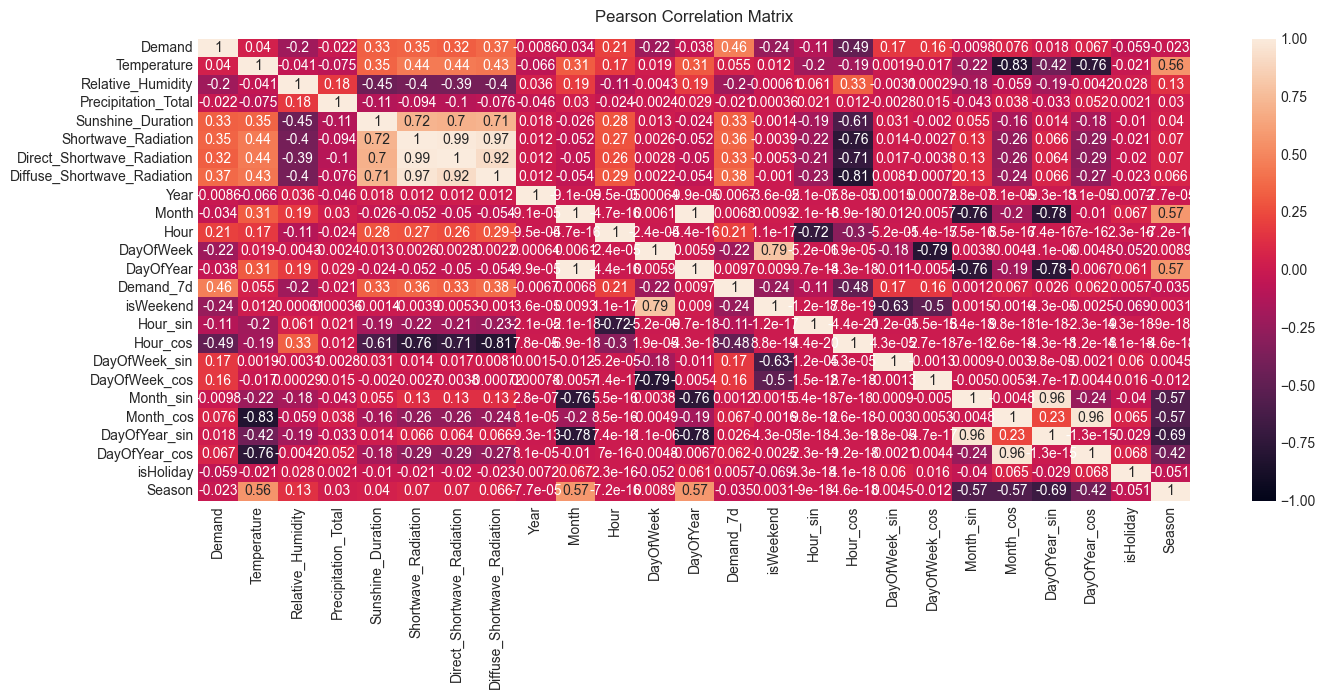

In [56]:
#Correlation Map using Pearson Correlation
plt.figure(figsize=(16,6))
corr_df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
#Drop Columns
corr_df = corr_df.drop(columns=["Date"])
heatmap = sns.heatmap(corr_df.corr('pearson'), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Pearson Correlation Matrix', fontdict={'fontsize': 12}, pad=12)

In [57]:
#columns2drop = ["Minute", "Year"]
#corr_df = corr_df.drop(columns=columns2drop)
trainingSize = int((parameters["dataset"]["trainingSize"] + parameters["dataset"]["validationSize"])* corr_df.shape[0])

X_new_train= corr_df.loc[:trainingSize, :].copy()
X_new_test = corr_df.loc[trainingSize:, :].copy()

new_model = KNeighborsRegressor(n_neighbors=100, weights='uniform')

test(X_train = X_new_train, X_test = X_new_test, model = new_model, type="All")

TypeError: test() got an unexpected keyword argument 'X_train'

### Battery tests

#### Set 12 KWh in Weekends

In [ ]:
df3 = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df3["Demand"][df3.isWeekend == True] = 12
df3["Demand"][df3.Hour < 8] = 12
df3["Demand"][df3.Hour > 20] = 12
dates = df3["Date"]

df3 = df3.drop(columns=["Date", "Minute", "Year"], axis=1)
trainingSize = int((parameters["dataset"]["trainingSize"] + parameters["dataset"]["validationSize"])* df3.shape[0])

X_train = df3.loc[:trainingSize, :].copy()
X_train_dates = dates.loc[:trainingSize].copy()
X_test = df3.loc[trainingSize:, :].copy()
X_test_dates = dates.loc[trainingSize:].copy()

model = KNeighborsRegressor(n_neighbors=33, weights='uniform')
test(X_train, X_test, model, "All")

Nº of Days Predicted: 109 == 10512 lags, Test MAE: 16.808553572252205, RMSE: 32.93509162857846
